In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from astropy.io import fits as fits
from astropy.table import Table
from astropy import constants as const
from astropy import units as u

from astropy.cosmology import Planck15 as planck
from astropy.table import QTable

import healpy as hp
#from healpy.newvisufunc import projview, newprojplot
import math

import sys
sys.path.append('/global/homes/l/lbigwood/LSS/py')
import LSS
import LSS.SV3
import LSS.SV3.cattools as cattools

#from desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, mws_mask 
from desitarget.targets import desi_mask, bgs_mask, mws_mask 

#files 
fba = '/project/projectdirs/desi/survey/catalogs/SV3/LSS/random0/fba-000175.fits'
all_randoms = '/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/random0/rancomb_brightwdup_Alltiles.fits'
brights = '/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/mtl/sv3/bright/sv3mtl-bright-hp-2287.ecsv'

nside = 32
orig_density_per_deg = 2500

### If you're not using a library, get rid of it. 

In [114]:
#Work out tile from rosette 
cattools.tile2rosette(201)

7

#### At the start, let's never use main survey files / masks and SV3 files / masks in the same notebook. 
#### Too dangerous!

In [116]:
def target_density(file, title='Randoms'):
    if file.endswith('.fits'):
        #read file
        f = fits.open(file)
        data=f[1].data
        
        #ensure targets dont repeat
        # need .data for astropy columns to arrays. 
        mask,idx = np.unique(data['TARGETID'].data,return_index=True)
        data = data[idx]
        
        longitude = data['RA']*u.deg
        latitude = data['DEC']*u.deg
        unique_target_list = data['TARGETID'].data
    
    elif file.endswith('.ecsv'):
        #read file
        data = Table.read(file)
        
        #ensure targets dont repeat
        mask,idx = np.unique(data['TARGETID'].data,return_index=True)
        data = data[idx]
        
        longitude = data['RA']
        latitude = data['DEC']
        unique_target_list = data['TARGETID'].data
    
    #set coordinate system, convert units and get rid of nan
    # longitude = longitude.to(u.radian)
    # longitude = longitude.value

    # longitude = longitude[~  np.isnan(longitude)]
    
    # latitude = latitude.to(u.radian)
    # latitude = latitude.value

    # co_latitude = (np.pi/2) - latitude

    # co_latitude = co_latitude[~  np.isnan(co_latitude)]
    
    #number of pixels on sphere and pixel area
    npix = hp.nside2npix(nside)
    pixel_area = hp.nside2pixarea(nside,degrees=True)

    #indices of pixels with non-zero density 
    # all_pixel_indices = hp.ang2pix(nside, co_latitude, longitude,nest=True)
    all_pixel_indices = hp.ang2pix(nside, data['RA'].data, data['DEC'].data,nest=True, lonlat=True)
        
    """
    #if want to plot histogram
    nbins=np.arange(all_pixel_indices.min(), all_pixel_indices.max(), 1)
    counts,bins,bars = plt.hist(all_pixel_indices,nbins)
    print(bins)
    plt.xlabel('Pixel index')
    plt.ylabel('Frequency')
    """

    filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

    #no. targets per pixel, initially 0 
    targets_per_pixel = np.zeros(hp.nside2npix(nside))
    
    #update no. targets per pixel 
    targets_per_pixel[filled_pixel_index] = filled_targets_per_pixel/pixel_area
    targets_per_pixel[targets_per_pixel == 0] = np.NaN 
    
    #mollview map of pixels
    hp.mollview(targets_per_pixel,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title=title)
    hp.graticule(dpar=5, dmer=5) 
    
    return unique_target_list, filled_pixel_index, filled_targets_per_pixel, pixel_area    

183.2512 deg^2
446.5042192523407 deg^2
183.25120000000004 deg^2


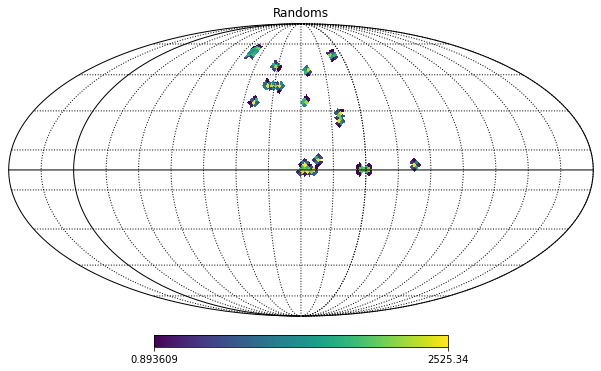

In [117]:
#for randoms 
unique_target_list,filled_pixel_index, filled_targets_per_pixel, pixel_area = target_density(all_randoms)

#correct pixel area based on actual vs expected density 
exp_density_per_pixel = pixel_area * orig_density_per_deg

random_corr_factor = filled_targets_per_pixel/exp_density_per_pixel
corr_pixel_area = pixel_area * random_corr_factor

#estimates for sv3 area
SV3_area = len(unique_target_list)/orig_density_per_deg
print('{} deg^2'.format(SV3_area))

SV3_area_2 = pixel_area*len(filled_pixel_index) 
print('{} deg^2'.format(SV3_area_2))

SV3_area_3 = np.sum(corr_pixel_area)
print('{} deg^2'.format(SV3_area_3))

## Don't get confused.  When you call random_corr_factor, this makes sense and will derive a filling factor.  When you call this on BGS targets, it makes no sense to talk of a corr_factor or filling factor.  We calculate the corr_factor based on randoms, and resuse this for BGS Bright, not recalculate it.  

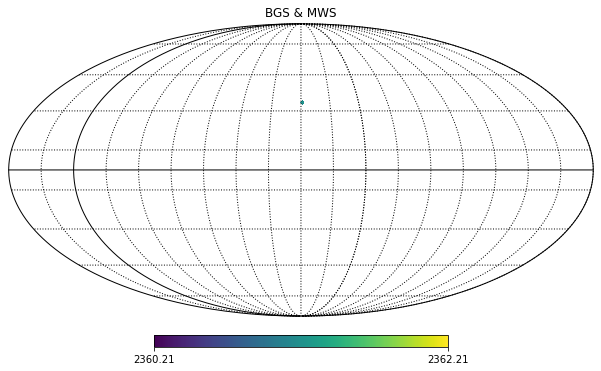

In [118]:
#get density of brights 
unique_target_list,filled_pixel_index, filled_targets_per_pixel, pixel_area = target_density(brights, title='BGS & MWS')

# densities per healpixel normalised by expected random density (i.e 2500/deg)
# Unfortunately not, we don't want to calculate corr_factor for targets, only randoms.  
# When we have it, we then apply it to the targets. 
# exp_density_per_pixel = pixel_area * orig_density_per_deg
# corr_factor = filled_targets_per_pixel/exp_density_per_pixel

In [119]:
#looking at brights priority
data = Table.read(brights)
        
#ensure targets dont repeat
mask,idx = np.unique(data['TARGETID'].data,return_index=True)
data = data[idx]

# masks of each type 
# NB:  this no longer makes any sense, as bgs_mask is a main survey mask. 
is_bright = (data["SV3_BGS_TARGET"].data & bgs_mask["BGS_BRIGHT"]) != 0
is_faint = (data["SV3_BGS_TARGET"].data & bgs_mask["BGS_FAINT"]) != 0
is_faint_hip = (data["SV3_BGS_TARGET"].data & bgs_mask["BGS_FAINT_HIP"]) != 0
is_agn = (data["SV3_BGS_TARGET"].data & bgs_mask["BGS_WISE"]) != 0

is_mws =  (data["SV3_MWS_TARGET"].data) != 0

bright,faint,faint_hip,agn = data[is_bright], data[is_faint], data[is_faint_hip], data[is_agn]
mws = data[is_mws]

#lists all targets and types
"""
bitnames = np.array(bgs_mask.names())  # ADM note the array conversion to help manipulation.
bitvals = [bgs_mask[name] for name in bitnames]
for data in data:
    w = np.where( (data["SV3_BGS_TARGET"] & bitvals) != 0)[0]
    print(data["SV3_BGS_TARGET"], bitnames[w])
"""

#bgs priorities
is_bgs = data["SV3_BGS_TARGET"].data != 0
#more standard day to write
is_bgs2 = (data['SV3_DESI_TARGET'].data & desi_mask['BGS_ANY']) != 0 
bgs = data[is_bgs2]
print(np.unique(bgs['PRIORITY'].data,return_counts=True))

#mws priorities 
is_mws = data["SV3_MWS_TARGET"].data != 0
#more standard way to write
is_mws2 = (data['SV3_DESI_TARGET'].data & desi_mask['MWS_ANY']) != 0 
mws = data[is_mws2]
print(np.unique(mws['PRIORITY'].data))

#looking at priorities of mws targets and overlaps 
is_wd = (data["SV3_MWS_TARGET"].data & mws_mask["MWS_WD"]) != 0
is_main_blue = (data["SV3_MWS_TARGET"].data & mws_mask["MWS_MAIN_BLUE"]) != 0

wd = data[is_wd]
main_blue = data[is_main_blue]
wd_main_blue = data[(is_wd & is_main_blue)]

print(np.unique(main_blue['PRIORITY'].data,return_counts=True))

(array([102000, 102100]), array([1683, 3150]))
[101400 101500 101550 101600 102998]
(array([101500, 101550, 102998]), array([1252,    3,    1]))


## Always import libraries, functions (from) at the top of code.

In [120]:
hp.nside2npix(nside)

12288

In [111]:
import glob, time 
from astropy.table import vstack 
# to_grab will be a list of file paths for files in the directory provided.  	 
#to_grab=glob.glob('/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/mtl/sv3/bright/sv3mtl-bright-hp-*.ecsv') 
to_grab=glob.glob('/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/mtl/main/bright/mtl-bright-hp-*.ecsv') 

# very good practice to apply sorted, otherwise the file ordering will be random 	and non-repeatable.  
to_grab = sorted(to_grab) 

hp_stack = []

start = time.time() 

npix_todo = 14000

mmask = 'BGS_TARGET'
ttype = 'BGS_BRIGHT'

for i, x in enumerate(to_grab):
    x = pd.read_csv(x, comment='#', delimiter='\s+', usecols=['RA', 'DEC', 'TARGETID', 'BGS_TARGET', 'MWS_TARGET'])

    is_main_blue = (x[mmask] & bgs_mask[ttype]) != 0

    idx = np.arange(len(x))[is_main_blue]
    
    x = x.iloc[idx] 
    
    hp_stack.append(x)

    if (i % 100) == 0:
        runtime = (time.time() - start)

        print('Runtime of {:.6f} seconds after {:d} pixels'.format(runtime, i))

    if i > npix_todo:
        break
        
# Create a big table from the list of tables.  
# data_stack = vstack(hp_stack) 

data_stack = pd.concat(hp_stack, ignore_index=True)

mask,idx = np.unique(data_stack['TARGETID'],return_index=True)
data_stack = data_stack.iloc[idx]

data_stack = Table.from_pandas(data_stack)

runtime = (time.time() - start)

print('\n\nTotal runtime of {:.6f} seconds after {:d} pixels'.format(runtime, npix_todo))

data_stack

Runtime of 0.043134 seconds after 0 pixels
Runtime of 3.397591 seconds after 100 pixels
Runtime of 9.436316 seconds after 200 pixels
Runtime of 14.419886 seconds after 300 pixels
Runtime of 21.360681 seconds after 400 pixels
Runtime of 26.848735 seconds after 500 pixels
Runtime of 31.159876 seconds after 600 pixels
Runtime of 35.399887 seconds after 700 pixels
Runtime of 40.620971 seconds after 800 pixels
Runtime of 43.930832 seconds after 900 pixels
Runtime of 46.839530 seconds after 1000 pixels
Runtime of 50.252365 seconds after 1100 pixels
Runtime of 55.695457 seconds after 1200 pixels
Runtime of 61.337956 seconds after 1300 pixels
Runtime of 67.373203 seconds after 1400 pixels
Runtime of 71.355279 seconds after 1500 pixels
Runtime of 75.900472 seconds after 1600 pixels
Runtime of 80.437385 seconds after 1700 pixels
Runtime of 85.405546 seconds after 1800 pixels
Runtime of 89.513327 seconds after 1900 pixels
Runtime of 95.447021 seconds after 2000 pixels
Runtime of 101.016998 second

RA,DEC,TARGETID,BGS_TARGET,MWS_TARGET
float64,float64,int64,int64,int64
59.60086559409994,-68.12683131313392,39626498281308189,131074,0
60.00983139575825,-68.16966639837612,39626498281308607,131074,0
60.01124019929327,-68.16379040745758,39626498281308610,131074,0
60.067316634746724,-68.1403940503445,39626498281308675,131074,0
60.27687723658043,-68.1477166136955,39626498285502547,131074,0
60.351730827700045,-68.1384524183673,39626498285502613,131074,0
60.35480903565853,-68.15736062454609,39626498285502619,131074,0
60.41502834204189,-68.14758441322456,39626498285502711,131074,0
60.57191230896668,-68.15293728255374,39626498285502939,131074,0


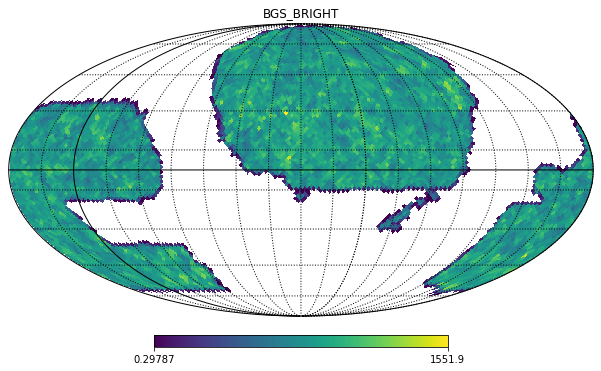

In [112]:
#indices of pixels with non-zero density 
# all_pixel_indices = hp.ang2pix(nside, co_latitude, longitude,nest=True)
all_pixel_indices = hp.ang2pix(nside, data_stack['RA'].data, data_stack['DEC'].data,nest=True, lonlat=True)

filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#correct area
exp_density_per_pixel = pixel_area * orig_density_per_deg
corr_factor = filled_targets_per_pixel/exp_density_per_pixel
corr_pixel_area = pixel_area * corr_factor

#update no. targets per pixel 
#no. targets per pixel, initially 0 
targets_per_pixel = np.zeros(hp.nside2npix(nside))

targets_per_pixel[filled_pixel_index] = filled_targets_per_pixel/pixel_area
targets_per_pixel[targets_per_pixel == 0] = np.NaN 

#mollview map of pixels
hp.mollview(targets_per_pixel,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title=ttype)
hp.graticule(dpar=5, dmer=5) 

[2286 2287 2333 2334 2335 2356 2357 2376 2378 2400 2453 2454 2455 2457
 2459 2460 2461 2462 2481 2495 2496 2498 2504 2536 2537 2538 2539 2557
 2559 2594 2595 2600 2601 2602 2628 2629 2630 2631 2679 2685 2803 2806
 2807 2809 2812 2813 2850 2851 2856 2857 2880 2881 2901 2903 2978 2984
 3838 3839 4010 4011 6398 6399 6477 6479 6481 6482 6483 6484 6486 6488
 6489 6490 6491 6492 6493 6494 6495 6509 6511 6513 6516 6517 6520 6521
 6522 6523 6562 6563 6568 6569 6570 6571 6572 6574 6608 6609 6740 6741
 6743 6809 6811 6812 6814 6815 6833 6836 6837 6912 6914 7031 7037]


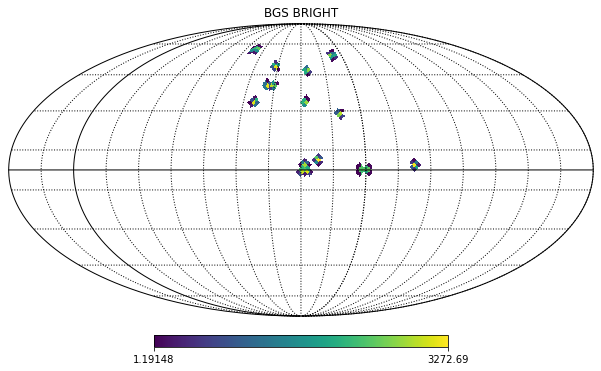

In [25]:
f = fits.open('/global/cscratch1/sd/mjwilson/desi/BGS/lumfn/MXXL/bright_v0.4.fits')
mxxl=f[1].data

bright_mxxl = mxxl[(mxxl['MRH'])<= -19.5]
faint_mxxl = mxxl[(mxxl['MRH'])> -19.5]

longitude = bright_mxxl['RA']*u.deg
latitude = bright_mxxl['DEC']*u.deg
unique_target_list = bright_mxxl['TARGETID']
    
#set coordinate system, convert units and get rid of nan
longitude = longitude.to(u.radian)
longitude = longitude.value

longitude = longitude[~  np.isnan(longitude)]

latitude = latitude.to(u.radian)
latitude = latitude.value

co_latitude = (np.pi/2) - latitude

co_latitude = co_latitude[~  np.isnan(co_latitude)]

#number of pixels on sphere and pixel area
npix = hp.nside2npix(nside)
pixel_area = hp.nside2pixarea(nside,degrees=True)

#indices of pixels with non-zero density 
all_pixel_indices = hp.ang2pix(nside, co_latitude, longitude,nest=True)

#no. targets per pixel, initially 0 
targets_per_pixel = np.zeros(hp.nside2npix(nside))

"""
#if want to plot histogram
nbins=np.arange(all_pixel_indices.min(), all_pixel_indices.max(), 1)
counts,bins,bars = plt.hist(all_pixel_indices,nbins)
print(bins)
plt.xlabel('Pixel index')
plt.ylabel('Frequency')
"""

filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#correct area
exp_density_per_pixel = pixel_area * orig_density_per_deg
corr_factor = filled_targets_per_pixel/exp_density_per_pixel
corr_pixel_area = pixel_area * corr_factor

#update no. targets per pixel 
targets_per_pixel[filled_pixel_index] = filled_targets_per_pixel/pixel_area
targets_per_pixel[targets_per_pixel == 0] = np.NaN 

#mollview map of pixels
hp.mollview(targets_per_pixel,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='BGS BRIGHT')
hp.graticule(dpar=5, dmer=5) 

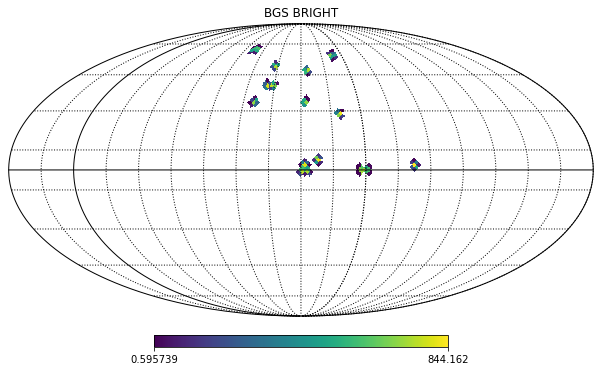

In [24]:
f = fits.open('/global/cscratch1/sd/mjwilson/desi/BGS/lumfn/MXXL/bright_v0.4.fits')
mxxl=f[1].data

bright_mxxl = mxxl[(mxxl['MRH'])<= -19.5]
faint_mxxl = mxxl[(mxxl['MRH'])> -19.5]

longitude = faint_mxxl['RA']*u.deg
latitude = faint_mxxl['DEC']*u.deg
unique_target_list = faint_mxxl['TARGETID']
    
#set coordinate system, convert units and get rid of nan
longitude = longitude.to(u.radian)
longitude = longitude.value

longitude = longitude[~  np.isnan(longitude)]

latitude = latitude.to(u.radian)
latitude = latitude.value

co_latitude = (np.pi/2) - latitude

co_latitude = co_latitude[~  np.isnan(co_latitude)]

#number of pixels on sphere and pixel area
npix = hp.nside2npix(nside)
pixel_area = hp.nside2pixarea(nside,degrees=True)

#indices of pixels with non-zero density 
all_pixel_indices = hp.ang2pix(nside, co_latitude, longitude,nest=True)

#no. targets per pixel, initially 0 
targets_per_pixel = np.zeros(hp.nside2npix(nside))

"""
#if want to plot histogram
nbins=np.arange(all_pixel_indices.min(), all_pixel_indices.max(), 1)
counts,bins,bars = plt.hist(all_pixel_indices,nbins)
print(bins)
plt.xlabel('Pixel index')
plt.ylabel('Frequency')
"""

filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#correct area
exp_density_per_pixel = pixel_area * orig_density_per_deg
corr_factor = filled_targets_per_pixel/exp_density_per_pixel
corr_pixel_area = pixel_area * corr_factor

#update no. targets per pixel 
targets_per_pixel[filled_pixel_index] = filled_targets_per_pixel/pixel_area
targets_per_pixel[targets_per_pixel == 0] = np.NaN 

#mollview map of pixels
hp.mollview(targets_per_pixel,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='BGS BRIGHT')
hp.graticule(dpar=5, dmer=5) 


In [ ]:

#move to new notebook
f = fits.open('/global/cscratch1/sd/mjwilson/desi/BGS/lumfn/MXXL/bright_v0.4.fits')
mxxl=f[1].data

bright_mxxl = mxxl[(mxxl['MRH'])<= -19.5]
faint_mxxl = mxxl[(mxxl['MRH'])> -19.5]

longitude = bright_mxxl['RA']*u.deg
latitude = bright_mxxl['DEC']*u.deg
unique_target_list = bright_mxxl['TARGETID']
    
#set coordinate system, convert units and get rid of nan
longitude = longitude.to(u.radian)
longitude = longitude.value

longitude = longitude[~  np.isnan(longitude)]

latitude = latitude.to(u.radian)
latitude = latitude.value

co_latitude = (np.pi/2) - latitude

co_latitude = co_latitude[~  np.isnan(co_latitude)]

#number of pixels on sphere and pixel area
npix = hp.nside2npix(nside)
pixel_area = hp.nside2pixarea(nside,degrees=True)

#indices of pixels with non-zero density 
all_pixel_indices = hp.ang2pix(nside, co_latitude, longitude,nest=True)

#no. targets per pixel, initially 0 
targets_per_pixel = np.zeros(hp.nside2npix(nside))

"""
#if want to plot histogram
nbins=np.arange(all_pixel_indices.min(), all_pixel_indices.max(), 1)
counts,bins,bars = plt.hist(all_pixel_indices,nbins)
print(bins)
plt.xlabel('Pixel index')
plt.ylabel('Frequency')
"""

filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#correct area
exp_density_per_pixel = pixel_area * orig_density_per_deg
corr_factor = filled_targets_per_pixel/exp_density_per_pixel
corr_pixel_area = pixel_area * corr_factor

#update no. targets per pixel 
targets_per_pixel[filled_pixel_index] = filled_targets_per_pixel/pixel_area
targets_per_pixel[targets_per_pixel == 0] = np.NaN 

#mollview map of pixels
hp.mollview(targets_per_pixel,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='BGS BRIGHT')
hp.graticule(dpar=5, dmer=5) 

mtldatamodel = np.array([], dtype=[ 

    ('RA', '>f8'), ('DEC', '>f8'), ('PARALLAX', '>f4'), 

    ('PMRA', '>f4'), ('PMDEC', '>f4'), ('REF_EPOCH', '>f4'), 

    ('DESI_TARGET', '>i8'), ('BGS_TARGET', '>i8'), ('MWS_TARGET', '>i8'), 

    ('SCND_TARGET', '>i8'), ('TARGETID', '>i8'), 

    ('SUBPRIORITY', '>f8'), ('OBSCONDITIONS', 'i4'), 

    ('PRIORITY_INIT', '>i8'), ('NUMOBS_INIT', '>i8'), ('PRIORITY', '>i8'), 

    ('NUMOBS', '>i8'), ('NUMOBS_MORE', '>i8'), ('Z', '>f8'), ('ZWARN', '>i8'), 

    ('TIMESTAMP', 'U25'), ('VERSION', 'U14'), ('TARGET_STATE', 'U30'), 

    ('ZTILEID', '>i4') 

    ]) 

 

t = Table(mtldatamodel) 

t.add_row((180., 90.0, 0.0, 0.0, 0.0, 0.0, 1152921504606846976, 512, 0, 0, 99, 0.1, 516, 102100, 9, 102100, 0, 9, -1.0, -1, '2021-04-04T23:05:09', '0.57.0', 'BGS|UNOBS', -1)) 

t.meta['AUTHOR'] = 'Leah Bigwood' 

t.meta['Mock'] = True 

t.write(/path/to/bigwood/S4MOCK/mockledger/sv3/bright/sv3mtl-bright-hp-2286.ecsv , format=’fits’, overwrite=True) 